In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from PIL import Image
import cv2
from glob import glob
from PIL import ImageEnhance, ImageFilter
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D


In [2]:
# Load features and prepare for training
features_df = pd.read_csv(r'C:\Users\fadhl\OneDrive\Desktop\Multimodal Data Preprocessing Assignment\results\image_features.csv')

In [3]:
features_df.head()

,member_id,image_path,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,feature_512
0,Fadh,C:\Users\fadhl\OneDrive\Desktop\Multimodal Dat...,Fadh,5.978198,0.0,0.0,0.510176,0.929504,2.626635,1.347956,...,3.364342,0.308304,0.144921,0.000000,14.787293,4.119032,0.168093,1.921428,0.696278,0.00000
1,Fadh,C:\Users\fadhl\OneDrive\Desktop\Multimodal Dat...,Fadh,3.516575,0.0,0.0,1.444859,0.000000,0.362488,0.962507,...,2.796328,0.000000,0.000000,0.047773,9.671034,3.235552,0.118595,4.965417,0.382181,0.00000
2,Fadh,C:\Users\fadhl\OneDrive\Desktop\Multimodal Dat...,Fadh,3.598576,0.0,0.0,1.952977,0.610571,4.702600,0.902978,...,2.703589,0.000000,1.079485,0.000000,8.447301,7.608152,0.934272,5.850784,1.576786,0.00000
3,Makuochi,C:\Users\fadhl\OneDrive\Desktop\Multimodal Dat...,Makuochi,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.718222,1.019715,0.219949,0.347722,0.518493,0.000000,0.000000,6.401627,1.258165,0.00000
4,Makuochi,C:\Users\fadhl\OneDrive\Desktop\Multimodal Dat...,Makuochi,0.000000,0.0,0.0,0.000000,0.016987,0.458915,0.000000,...,0.428487,0.909549,1.469509,1.026957,2.480491,0.061797,0.800689,4.881014,0.141702,0.03587


In [4]:
# Separate features (X) and labels (y)
feature_columns = [col for col in features_df.columns if col.startswith('feature_')]
X = features_df[feature_columns].values
y = features_df['label'].values


In [5]:
y

array(['Fadh', 'Fadh', 'Fadh', 'Makuochi', 'Makuochi', 'Makuochi',
       'Mugisha', 'Mugisha', 'Mugisha', 'Fadh', 'Fadh', 'Fadh', 'Fadh',
       'Fadh', 'Fadh', 'Fadh', 'Fadh', 'Fadh', 'Fadh', 'Fadh', 'Fadh',
       'Makuochi', 'Makuochi', 'Makuochi', 'Makuochi', 'Makuochi',
       'Makuochi', 'Makuochi', 'Makuochi', 'Makuochi', 'Makuochi',
       'Makuochi', 'Makuochi', 'Mugisha', 'Mugisha', 'Mugisha', 'Mugisha',
       'Mugisha', 'Mugisha', 'Mugisha', 'Mugisha', 'Mugisha', 'Mugisha',
       'Mugisha', 'Mugisha'], dtype=object)

In [6]:
print("="*60)
print("DATASET INFORMATION")
print("="*60)
print(f"Feature matrix shape: {X.shape}")
print(f"  - Number of samples: {X.shape[0]}")
print(f"  - Number of features per sample: {X.shape[1]}")
print(f"\nLabels shape: {y.shape}")
print(f"Unique labels: {np.unique(y)}")
print(f"Number of classes: {len(np.unique(y))}")

DATASET INFORMATION
Feature matrix shape: (45, 512)
  - Number of samples: 45
  - Number of features per sample: 512

Labels shape: (45,)
Unique labels: ['Fadh' 'Makuochi' 'Mugisha']
Number of classes: 3


In [7]:
# Encode labels to numbers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [8]:
for i, label in enumerate(label_encoder.classes_):
    count = np.sum(y_encoded == i)
    print(f"  {label} → {i} ({count} samples)")

  Fadh → 0 (15 samples)
  Makuochi → 1 (15 samples)
  Mugisha → 2 (15 samples)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.25,
    random_state=42,
    stratify=y_encoded
)


In [10]:
print(f"Training set:   {X_train.shape[0]:3d} samples ({X_train.shape[0]/len(X)*100:5.1f}%)")
print(f"Test set:       {X_test.shape[0]:3d} samples ({X_test.shape[0]/len(X)*100:5.1f}%)")
print(f"Total:          {len(X):3d} samples (100.0%)")

Training set:    33 samples ( 73.3%)
Test set:        12 samples ( 26.7%)
Total:           45 samples (100.0%)


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
xgb_model = XGBClassifier(
    n_estimators=50,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    max_depth=2
)

xgb_model.fit(X_train_scaled, y_train)

print("✓ XGBoost model trained successfully")

✓ XGBoost model trained successfully


In [13]:
# rf_model = RandomForestClassifier(
#     n_estimators=100,
#     random_state=42,
#     n_jobs=-1,
#     max_depth=10
# )

# rf_model.fit(X_train_scaled, y_train)


In [14]:
y_train_pred = xgb_model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)

print("\n--- Training Set Evaluation ---")
print(f"Accuracy: {train_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))



--- Training Set Evaluation ---
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        11

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



In [15]:
y_test_pred = xgb_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\n--- Testing Set Evaluation ---")
print(f"Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


--- Testing Set Evaluation ---
Accuracy: 0.7500

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.75      0.75      0.75         4
           2       0.75      0.75      0.75         4

    accuracy                           0.75        12
   macro avg       0.75      0.75      0.75        12
weighted avg       0.75      0.75      0.75        12



In [16]:
# Save trained model and preprocessing objects
models_path = r'C:\Users\fadhl\OneDrive\Desktop\Multimodal Data Preprocessing Assignment\models'
os.makedirs(models_path, exist_ok=True)


# Save model
model_file = os.path.join(models_path, 'face_recognition_model.pkl')
with open(model_file, 'wb') as f:
    pickle.dump(xgb_model, f)
print(f"✓ Model saved: {model_file}")

# Save scaler
scaler_file = os.path.join(models_path, 'face_scaler.pkl')
with open(scaler_file, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✓ Scaler saved: {scaler_file}")

# Save label encoder
encoder_file = os.path.join(models_path, 'face_label_encoder.pkl')
with open(encoder_file, 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"✓ Label encoder saved: {encoder_file}")

✓ Model saved: C:\Users\fadhl\OneDrive\Desktop\Multimodal Data Preprocessing Assignment\models\face_recognition_model.pkl
✓ Scaler saved: C:\Users\fadhl\OneDrive\Desktop\Multimodal Data Preprocessing Assignment\models\face_scaler.pkl
✓ Label encoder saved: C:\Users\fadhl\OneDrive\Desktop\Multimodal Data Preprocessing Assignment\models\face_label_encoder.pkl


## TESTING THE MODEL

In [17]:
# Create function to predict on new images
def predict_face(image_path, model, scaler, label_encoder, feature_extractor):
    """
    Predict identity from an image
    
    Args:
        image_path: Path to the image file
        model: Trained classification model
        scaler: Fitted StandardScaler
        label_encoder: Fitted LabelEncoder
        feature_extractor: VGG16 feature extraction model
    
    Returns:
        predicted_label: Predicted person's name
        confidence: Prediction confidence (probability)
    """
    # Load and preprocess image
    img = keras_image.load_img(image_path, target_size=(224, 224))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Extract features
    features = feature_extractor.predict(img_array, verbose=0)
    features = features.flatten().reshape(1, -1)
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Predict
    prediction = model.predict(features_scaled)
    predicted_label = label_encoder.inverse_transform(prediction)[0]
    
    # Get prediction probability (confidence)
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(features_scaled)[0]
        confidence = np.max(probabilities)
        all_probs = dict(zip(label_encoder.classes_, probabilities))
    else:
        confidence = 1.0
        all_probs = {predicted_label: 1.0}
    
    return predicted_label, confidence, all_probs

print("✓ Prediction function created")

✓ Prediction function created


In [18]:
feature_extractor = load_model(r'C:\Users\fadhl\OneDrive\Desktop\Multimodal Data Preprocessing Assignment\models\feature_extractor.h5')


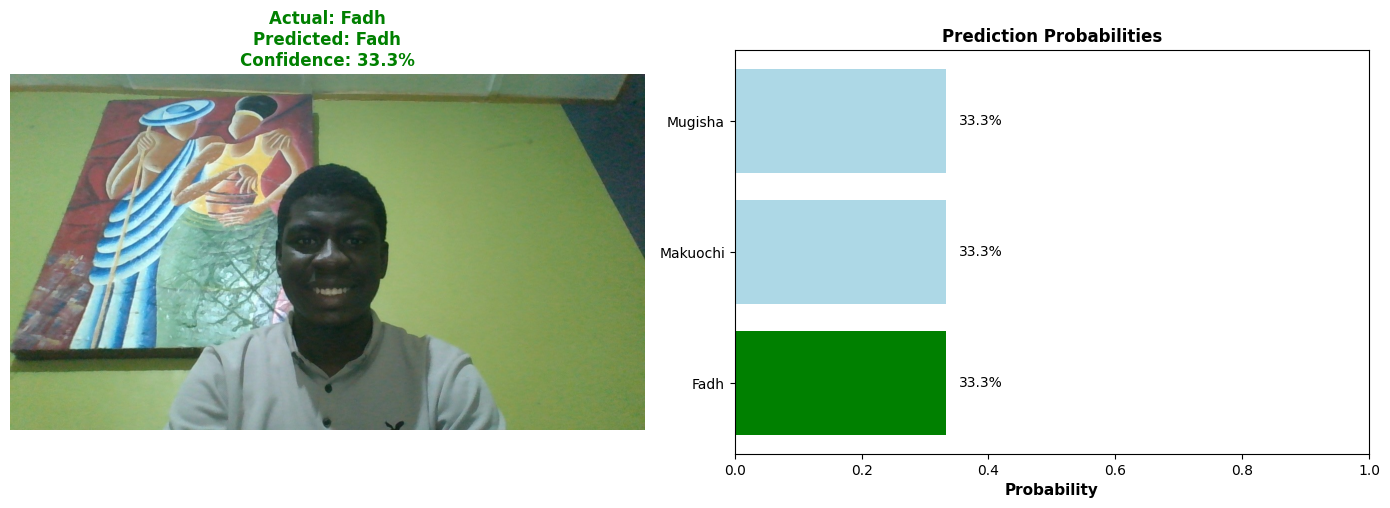

Image: Fadh_test1.jpg
Actual: Fadh
Predicted: Fadh
Confidence: 33.33%
Result: ✓ CORRECT


In [19]:
# Test on ONE specific image
def test_single_image(image_path):
    """Test prediction on a single image"""
    
    # Get prediction
    predicted_name, confidence, all_probs = predict_face(
        image_path, 
        xgb_model, 
        scaler, 
        label_encoder, 
        feature_extractor
    )
    
    # Get actual name from filename
    actual_name = os.path.basename(image_path).split('_')[0]
    
    # Display result
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Show image
    img = Image.open(image_path)
    ax1.imshow(img)
    color = 'green' if predicted_name == actual_name else 'red'
    ax1.set_title(f"Actual: {actual_name}\nPredicted: {predicted_name}\nConfidence: {confidence:.1%}", 
                  fontsize=12, fontweight='bold', color=color)
    ax1.axis('off')
    
    # Show probability bars
    members = list(all_probs.keys())
    probs = list(all_probs.values())
    colors = ['green' if m == predicted_name else 'lightblue' for m in members]
    
    ax2.barh(members, probs, color=colors)
    ax2.set_xlabel('Probability', fontsize=11, fontweight='bold')
    ax2.set_title('Prediction Probabilities', fontsize=12, fontweight='bold')
    ax2.set_xlim([0, 1])
    
    # Add probability values
    for i, (member, prob) in enumerate(zip(members, probs)):
        ax2.text(prob + 0.02, i, f'{prob:.1%}', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print results
    
    print(f"Image: {os.path.basename(image_path)}")
    print(f"Actual: {actual_name}")
    print(f"Predicted: {predicted_name}")
    print(f"Confidence: {confidence:.2%}")
    print(f"Result: {'✓ CORRECT' if predicted_name == actual_name else '✗ WRONG'}")

test_single_image(r'C:\Users\fadhl\OneDrive\Desktop\Multimodal Data Preprocessing Assignment\Fadh_test1.jpg')

In [20]:
# Test on unknown person
unknown_image = r'C:\Users\fadhl\OneDrive\Desktop\Multimodal Data Preprocessing Assignment\Abubakar_test_2.jpg'

predicted_name, confidence, all_probs = predict_face(
    unknown_image, 
    xgb_model, 
    scaler, 
    label_encoder, 
    feature_extractor
)

print("Testing on UNKNOWN person:")
print(f"Model predicted: {predicted_name}")
print(f"Confidence: {confidence:.2%}")

if confidence < 0.70:  # Low confidence threshold
    print("⚠️  Low confidence - Likely an unknown person")
else:
    print(f"Model thinks this is {predicted_name} with high confidence")

Testing on UNKNOWN person:
Model predicted: Makuochi
Confidence: 49.44%
⚠️  Low confidence - Likely an unknown person
